In [1]:
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace(".", " .")
    words = text.split(" ")
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [2]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print("corpus:", corpus)
print("word_to_id:", word_to_id)
print("id_to_word:", id_to_word)

corpus: [0 1 2 3 4 1 5 6]
word_to_id: {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
id_to_word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [3]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [4]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [5]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


In [6]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print("%s is not found" % query)
        return
    
    print("\n[query] " + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(" %s: %s" % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [7]:
x = np.array([100, -20, 2])
x.argsort()

array([1, 2, 0])

In [8]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [9]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print("%.1f%% done" % (100*cnt/total))
    return M

In [11]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print("covariance matrix")
print(C)
print("-"*50)
print("PPMI")
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [13]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

U, S, V = np.linalg.svd(W)
print(C[0])
print(W[0])

print(U[0])
print(U[0, :2])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00  1.205e-01 -3.608e-16 -1.110e-16  9.323e-01
  1.626e-16]
[0.341 0.   ]


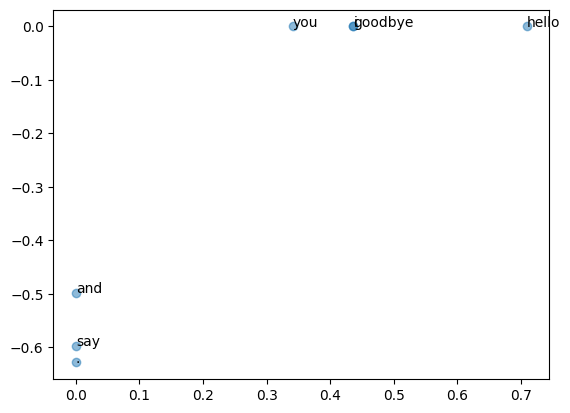

In [14]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [15]:
import sys
sys.path.append('..')
from nndataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
print("corpus size:", len(corpus))
print("corpus[:30]:", corpus[:30])
print()
print("id_to_word[0]:", id_to_word[0])
print("id_to_word[1]:", id_to_word[1])
print("id_to_word[2]:", id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [17]:
!pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/83/74/f64379a4ed5879d9db744fe37cfe1978c07c66684d2439c3060d19a536d8/scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/5c/c0/e71b94b20ccf9effb38d7147c0064c08c622309fd487b1b677771a97d18c/scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00-:--:--
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/

In [18]:
import sys
sys.path.append('..')
from nndataset import ptb
from common.util import most_similar, create_co_matrix, ppmi
window_size=2
wordvec_size=100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size)
W = ppmi(C, verbose=True)

try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% done
89.0% done
90.0% done
91.0% done
92.0% do